<a href="https://colab.research.google.com/github/MIARD/SMC/blob/main/WM_SMC_ML_APP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import os
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
pd.set_option('display.max_rows', None)

##Overall Ratio Functions

In [27]:
def predict_for_combinations(date_input, CL, CW, training_feature_cols, regular_binary_models, model_keys, model_names, precomputed_stats, criteria_values=None, time_values=None):

    if criteria_values is None:
      criteria_values = set()
      for key in precomputed_stats:
        if key[0] == 'Criteria':
            criteria_values.add(key[1])
    if time_values is None:
      time_values = set()
      for key in precomputed_stats:
        if key[0] == '15Min':
            time_values.add(key[1])

    criteria_values = sorted(list(criteria_values))
    time_values = sorted(list(time_values))
    print(f"Unique Criteria: {criteria_values}")
    print(f"Unique 15Min: {time_values}")


    prediction_results = []
    for time_input in time_values:
        if len(prediction_results) % 1000 == 0:
          print("processsing.........:", time_input)
        for criteria_input in criteria_values:

            input_features = get_train_data_for_input(
                precomputed_stats,
                time_input,
                date_input,
                criteria_input,
                training_feature_cols
            )

            if not input_features.empty:
                input_features['CL'] = CL
                input_features['CW'] = CW
                binary_predictions_sum = 0
                for model in regular_binary_models:
                    pred_bin, _ = predict_trade_result(model, input_features, training_feature_cols)
                    if pred_bin is not None:
                        binary_predictions_sum += pred_bin

                prediction_results.append({
                    'Time': time_input,
                    'Criteria': criteria_input,
                    'Binary_Prediction_Sum': binary_predictions_sum
                })

    predictions_df = pd.DataFrame(prediction_results)
    return predictions_df

In [30]:
def plot_prediction_heatmap(df, date, invert=False, interactive=False):
    if df.empty:
        print("No data to plot.")
        return

    idx, cols = ('Criteria', 'Time')
    if invert: idx, cols = cols, idx

    heatmap = df.pivot(index=idx, columns=cols, values='Binary_Prediction_Sum')
    heatmap = heatmap.reindex(columns=sorted(heatmap.columns))

    if not invert:
        bottom_rows = pd.concat([
            heatmap.sum(axis=0).to_frame().T.rename(index={0: 'Total Predicted Count'}),
            (heatmap > 0).sum(axis=0).to_frame().T.rename(index={0: 'Total Criteria Pred Count'})
        ])
        heatmap = pd.concat([heatmap, bottom_rows])
    else:
        heatmap['Total Predicted Count'] = heatmap.sum(axis=1)
        heatmap['Total Criteria Pred Count'] = (heatmap > 0).sum(axis=1)

    if interactive:
        base_size = 30
        fig = px.imshow(
            heatmap.values, x=heatmap.columns, y=heatmap.index,
            text_auto=True, color_continuous_scale='viridis',
            labels={'x': cols, 'y': idx, 'color': 'Prediction Sum'},
            title=f"Binary Predictions Heatmap - {date}"
        )
        fig.update_layout(
            autosize=False,
            width=min(1500, max(400, heatmap.shape[1] * base_size)),
            height=min(1000, max(300, heatmap.shape[0] * base_size)),
            margin=dict(l=40, r=40, t=80, b=40),
            font=dict(size=12)
        )
        fig.show()
        return heatmap

    mask = np.zeros_like(heatmap, dtype=bool)
    if not invert:
        mask[-2:, :] = True
    else:
        mask[:, -2:] = True

    plt.figure(figsize=(heatmap.shape[1] * 0.3, heatmap.shape[0] * 0.3))
    ax = sns.heatmap(heatmap, annot=True, fmt='d', cmap='viridis', linewidths=0.5, mask=mask)

    # Annotate masked cells with gray background
    if not invert:
        rows = range(len(heatmap) - 2, len(heatmap))
        for r in rows:
            for c in range(len(heatmap.columns)):
                val = int(heatmap.iloc[r, c])
                ax.text(c + 0.5, r + 0.5, str(val), ha='center', va='center',
                        color='black', fontsize=9,
                        bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round,pad=0.2'))
    else:
        cols = range(len(heatmap.columns) - 2, len(heatmap.columns))
        for c in cols:
            for r in range(len(heatmap)):
                val = int(heatmap.iloc[r, c])
                ax.text(c + 0.5, r + 0.5, str(val), ha='center', va='center',
                        color='black', fontsize=9,
                        bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round,pad=0.2'))

    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', labeltop=True, top=True, bottom=True, rotation=90)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, left=True, right=True, rotation=0)

    plt.title(f'Sum of Binary Predictions Heatmap - {date}')
    plt.xlabel('Start Time' if not invert else 'Criteria')
    plt.ylabel('Criteria' if not invert else 'Start Time')
    plt.tight_layout()
    plt.show()

    return heatmap

##Get Feature Data & Train Data From Input

In [21]:
def get_feature_data(precomputed_stats, index, row):
    # Retrieve stats for individual features
    row_data = {}
    time_15min = row['15Min']
    trade_count_15m, pl_15m, win_rate_15m = precomputed_stats[('15Min', time_15min)]
    row_data['15Min_Trade Count'] = trade_count_15m
    row_data['15Min_Win Rate'] = win_rate_15m
    row_data['15Min_Profit/Loss'] = pl_15m

    hour = row['Hour']
    trade_count_hour, pl_hour, win_rate_hour = precomputed_stats[('Hour', hour)]
    row_data['Hour_Trade Count'] = trade_count_hour
    row_data['Hour_Win Rate'] = win_rate_hour
    row_data['Hour_Profit/Loss'] = pl_hour
    weekday = row['Start_Weekday']
    trade_count_weekday, pl_weekday, win_rate_weekday = precomputed_stats[('Weekday', weekday)]
    row_data['Weekday_Trade Count'] = trade_count_weekday
    row_data['Weekday_Win Rate'] = win_rate_weekday
    row_data['Weekday_Profit/Loss'] = pl_weekday

    month = row['Month']
    trade_count_month, pl_month, win_rate_month = precomputed_stats[('Month', month)]
    row_data['Month_Trade Count'] = trade_count_month
    row_data['Month_Win Rate'] = win_rate_month
    row_data['Month_Profit/Loss'] = pl_month

    criteria = row['Criteria']
    trade_count_criteria, pl_criteria, win_rate_criteria = precomputed_stats[('Criteria', criteria)]
    row_data['Criteria_Trade Count'] = trade_count_criteria
    row_data['Criteria_Win Rate'] = win_rate_criteria
    row_data['Criteria_Profit/Loss'] = pl_criteria

    # Add features for Day of Month and Week of Month
    day_of_month = row['Day_of_Month']
    trade_count_day, pl_day, win_rate_day = precomputed_stats[('Day_of_Month', day_of_month)]
    row_data['Day_of_Month_Trade Count'] = trade_count_day
    row_data['Day_of_Month_Win Rate'] = win_rate_day
    row_data['Day_of_Month_Profit/Loss'] = pl_day

    week_of_month = row['Week_of_Month']
    trade_count_week, pl_week, win_rate_week = precomputed_stats[('Week_of_Month', week_of_month)]
    row_data['Week_of_Month_Trade Count'] = trade_count_week
    row_data['Week_of_Month_Win Rate'] = win_rate_week
    row_data['Week_of_Month_Profit/Loss'] = pl_week

    # Retrieve stats for combined features
    trade_count_weekday_15m, pl_weekday_15m, win_rate_weekday_15m = precomputed_stats[('Weekday_15Min', weekday, time_15min)]
    row_data['Weekday_15Min_Trade Count'] = trade_count_weekday_15m
    row_data['Weekday_15Min_Win Rate'] = win_rate_weekday_15m
    row_data['Weekday_15Min_Profit/Loss'] = pl_weekday_15m

    trade_count_weekday_hour, pl_weekday_hour, win_rate_weekday_hour = precomputed_stats[('Weekday_Hour', weekday, hour)]
    row_data['Weekday_Hour_Trade Count'] = trade_count_weekday_hour
    row_data['Weekday_Hour_Win Rate'] = win_rate_weekday_hour
    row_data['Weekday_Hour_Profit/Loss'] = pl_weekday_hour

    trade_count_weekday_month, pl_weekday_month, win_rate_weekday_month = precomputed_stats[('Weekday_Month', weekday, month)]
    row_data['Weekday_Month_Trade Count'] = trade_count_weekday_month
    row_data['Weekday_Month_Win Rate'] = win_rate_weekday_month
    row_data['Weekday_Month_Profit/Loss'] = pl_weekday_month

    trade_count_criteria_15m, pl_criteria_15m, win_rate_criteria_15m = precomputed_stats[('Criteria_15Min', criteria, time_15min)]
    row_data['Criteria_15Min_Trade Count'] = trade_count_criteria_15m
    row_data['Criteria_15Min_Win Rate'] = win_rate_criteria_15m
    row_data['Criteria_15Min_Profit/Loss'] = pl_criteria_15m

    trade_count_criteria_hour, pl_criteria_hour, win_rate_criteria_hour = precomputed_stats[('Criteria_Hour', criteria, hour)]
    row_data['Criteria_Hour_Trade Count'] = trade_count_criteria_hour
    row_data['Criteria_Hour_Win Rate'] = win_rate_criteria_hour
    row_data['Criteria_Hour_Profit/Loss'] = pl_criteria_hour

    trade_count_criteria_weekday, pl_criteria_weekday, win_rate_criteria_weekday = precomputed_stats[('Criteria_Weekday', criteria, weekday)]
    row_data['Criteria_Weekday_Trade Count'] = trade_count_criteria_weekday
    row_data['Criteria_Weekday_Win Rate'] = win_rate_criteria_weekday
    row_data['Criteria_Weekday_Profit/Loss'] = pl_criteria_weekday

    trade_count_criteria_month, pl_criteria_month, win_rate_criteria_month = precomputed_stats[('Criteria_Month', criteria, month)]
    row_data['Criteria_Month_Trade Count'] = trade_count_criteria_month
    row_data['Criteria_Month_Win Rate'] = win_rate_criteria_month
    row_data['Criteria_Month_Profit/Loss'] = pl_criteria_month

    trade_count_hour_month, pl_hour_month, win_rate_hour_month = precomputed_stats[('Hour_Month', hour, month)]
    row_data['Hour_Month_Trade Count'] = trade_count_hour_month
    row_data['Hour_Month_Win Rate'] = win_rate_hour_month
    row_data['Hour_Month_Profit/Loss'] = pl_hour_month

    trade_count_15min_month, pl_15min_month, win_rate_15min_month = precomputed_stats[('15Min_Month', time_15min, month)]
    row_data['15Min_Month_Trade Count'] = trade_count_15min_month
    row_data['15Min_Month_Win Rate'] = win_rate_15min_month
    row_data['15Min_Month_Profit/Loss'] = pl_15min_month

    # Add combined features for Day of Month and Week of Month
    trade_count_weekday_day, pl_weekday_day, win_rate_weekday_day = precomputed_stats[('Weekday_Day', weekday, day_of_month)]
    row_data['Weekday_Day_Trade Count'] = trade_count_weekday_day
    row_data['Weekday_Day_Win Rate'] = win_rate_weekday_day
    row_data['Weekday_Day_Profit/Loss'] = pl_weekday_day

    trade_count_weekday_week, pl_weekday_week, win_rate_weekday_week = precomputed_stats[('Weekday_Week', weekday, week_of_month)]
    row_data['Weekday_Week_Trade Count'] = trade_count_weekday_week
    row_data['Weekday_Week_Win Rate'] = win_rate_weekday_week
    row_data['Weekday_Week_Profit/Loss'] = pl_weekday_week

    trade_count_criteria_day, pl_criteria_day, win_rate_criteria_day = precomputed_stats[('Criteria_Day', criteria, day_of_month)]
    row_data['Criteria_Day_Trade Count'] = trade_count_criteria_day
    row_data['Criteria_Day_Win Rate'] = win_rate_criteria_day
    row_data['Criteria_Day_Profit/Loss'] = pl_criteria_day

    trade_count_criteria_week, pl_criteria_week, win_rate_criteria_week = precomputed_stats[('Criteria_Week', criteria, week_of_month)]
    row_data['Criteria_Week_Trade Count'] = trade_count_criteria_week
    row_data['Criteria_Week_Win Rate'] = win_rate_criteria_week
    row_data['Criteria_Week_Profit/Loss'] = pl_criteria_week

    trade_count_hour_day, pl_hour_day, win_rate_hour_day = precomputed_stats[('Hour_Day', hour, day_of_month)]
    row_data['Hour_Day_Trade Count'] = trade_count_hour_day
    row_data['Hour_Day_Win Rate'] = win_rate_hour_day
    row_data['Hour_Day_Profit/Loss'] = pl_hour_day

    trade_count_hour_week, pl_hour_week, win_rate_hour_week = precomputed_stats[('Hour_Week', hour, week_of_month)]
    row_data['Hour_Week_Trade Count'] = trade_count_hour_week
    row_data['Hour_Week_Win Rate'] = win_rate_hour_week
    row_data['Hour_Week_Profit/Loss'] = pl_hour_week

    trade_count_15min_day, pl_15min_day, win_rate_15min_day = precomputed_stats[('15Min_Day', time_15min, day_of_month)]
    row_data['15Min_Day_Trade Count'] = trade_count_15min_day
    row_data['15Min_Day_Win Rate'] = win_rate_15min_day
    row_data['15Min_Day_Profit/Loss'] = pl_15min_day

    trade_count_15min_week, pl_15min_week, win_rate_15min_week = precomputed_stats[('15Min_Week', time_15min, week_of_month)]
    row_data['15Min_Week_Trade Count'] = trade_count_15min_week
    row_data['15Min_Week_Win Rate'] = win_rate_15min_week
    row_data['15Min_Week_Profit/Loss'] = pl_15min_week

    trade_count_month_day, pl_month_day, win_rate_month_day = precomputed_stats[('Month_Day', month, day_of_month)]
    row_data['Month_Day_Trade Count'] = trade_count_month_day
    row_data['Month_Day_Win Rate'] = win_rate_month_day
    row_data['Month_Day_Profit/Loss'] = pl_month_day

    trade_count_month_week, pl_month_week, win_rate_month_week = precomputed_stats[('Month_Week', month, week_of_month)]
    row_data['Month_Week_Trade Count'] = trade_count_month_week
    row_data['Month_Week_Win Rate'] = win_rate_month_week
    row_data['Month_Week_Profit/Loss'] = pl_month_week

    trade_count_day_week, pl_day_week, win_rate_day_week = precomputed_stats[('Day_Week', day_of_month, week_of_month)]
    row_data['Day_Week_Trade Count'] = trade_count_day_week
    row_data['Day_Week_Win Rate'] = win_rate_day_week
    row_data['Day_Week_Profit/Loss'] = pl_day_week

    return row_data

In [19]:
def get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols):

    # Convert inputs
    try:
        input_time = datetime.strptime(time_input, '%H:%M').time()
    except ValueError:
        print("Invalid time format. Use HH:MM.")
        return pd.DataFrame()

    try:
        input_date = datetime.strptime(date_input, '%m/%d/%Y')
    except ValueError:
        print("Invalid date format. Use M/D/YYYY.")
        return pd.DataFrame()

    row_data = {}
    input_datetime = datetime.combine(input_date, input_time)
    time_15min = input_datetime.strftime('%H:%M')
    hour = input_datetime.hour
    weekday = input_datetime.strftime('%A')
    month = input_datetime.strftime('%B')
    criteria = criteria_input
    day_of_month = input_datetime.day
    week_of_month = (input_datetime.day - 1) // 7 + 1

    # Retrieve stats from precomputed_stats dictionary
    try:
        row = {'15Min': time_15min, 'Hour': hour, 'Start_Weekday': weekday, 'Month': month, 'Criteria': criteria, 'Day_of_Month':day_of_month, 'Week_of_Month':week_of_month}
        row_data = get_feature_data(precomputed_stats, 0, row)

    except KeyError as e:
        print(f"Error: Missing precomputed statistic for key {e}. Ensure create_precomputed_stats covers all combinations you need.")
        return pd.DataFrame()


    # Create DataFrame from the calculated row_data
    input_features_df = pd.DataFrame([row_data])
    # Reindex the input_features_df to match the training columns, filling missing with 0
    input_features_df = input_features_df.reindex(columns=training_feature_cols, fill_value=0)

    return input_features_df


##Show Prediciton

In [23]:
def predict_trade_result(model, input_features_df, training_feature_cols):

    if input_features_df.empty:
        print("Cannot predict: Invalid input features.")
        return None, None

    # Make prediction
    input_features_df = input_features_df[training_feature_cols]
    predicted_class = model.predict(input_features_df)[0]
    if predicted_class == 0:
        predicted_proba = model.predict_proba(input_features_df)
    else:
        predicted_proba = model.predict_proba(input_features_df)

    return predicted_class, predicted_proba

In [17]:
def show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols,model_names, model_keys, precomputed_stats=None,label_encoder=None, b_models=None, m_models=None, b_acc=None, m_acc=None, Max_R=False, s_print=True, w_threshold=1):
    mr = "_max_r" if Max_R else ""
    # Initialize models and their keys
    binary_models = b_models if b_models is not None else [globals()[f"{k}_model{mr}"] for k in model_keys]
    binary_accuracies = b_acc if b_acc is not None else [globals()[f"{k}_accuracy{mr}"] for k in model_keys]

    multiclass_models = m_models if m_models is not None else [globals()[f"{k}_model_m{mr}"] for k in model_keys]
    multiclass_accuracies = m_acc if m_acc is not None else [globals()[f"{k}_accuracy_m{mr}"] for k in model_keys]

    time_input = datetime.strptime(time_input, '%H:%M').strftime('%H:%M')
    date_input = datetime.strptime(date_input, '%m/%d/%Y').strftime('%m/%d/%Y')
    if s_print:
      print(f"input:{date_input} {time_input} Criteria: {criteria_input} CL: {CL} CW: {CW}")

    input_features = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
    input_features['CL'] = [CL]
    input_features['CW'] = [CW]
    predictions = []
    predictions_multi = []
    if not input_features.empty:
        table_data = []

        for i, name in enumerate(model_names):
            # Predict binary
            pred_bin, prob_bin = predict_trade_result(binary_models[i], input_features, training_feature_cols)
            label_bin = 'Win' if pred_bin == 1 else 'Loss'
            acc_bin = f"{binary_accuracies[i]:.2f}"
            bin_str = f"{label_bin} ({np.max(prob_bin):.2f}), Acc: {acc_bin}"

            # Predict multiclass
            pred_multi, prob_multi = predict_trade_result(multiclass_models[i], input_features, training_feature_cols)
            acc_multi = f"{multiclass_accuracies[i]:.2f}"
            multi_str = f"Class {label_encoder.inverse_transform([pred_multi])[0]} ({np.max(prob_multi):.2f}), Acc: {acc_multi}"
            table_data.append([name, bin_str, multi_str])
            predictions.append(pred_bin)
            predictions_multi.append(pred_multi)
        predicted_win = predictions.count(1)
        predicted_loss = predictions.count(0)
        predicted_win_multi = len(predictions)-predictions_multi.count(0)
        predicted_loss_multi = predictions_multi.count(0)
        trade_decision = "Win" if predicted_win > w_threshold else "Loss"
        trade_decision_multi = "Win" if predicted_win_multi >= w_threshold else "Loss"
        predictions_multi = label_encoder.inverse_transform(predictions_multi).tolist()
        max_r = "" if trade_decision_multi == "Loss" else "- Max R: "+str(np.max(predictions_multi))
        avg_r = "" if trade_decision_multi == "Loss" else "- Average R:"+str(np.mean([x for x in predictions_multi if x>0]))
        # Display table
        if s_print:
            print(f"\n--- 📊 Combined Model Predictions for {date_input} {time_input} ({criteria_input}) -{mr} ---\n")
            print(f"Overall decision: ---- Binary: ** {trade_decision} **  Multi: ** {trade_decision_multi}** ---- {max_r} {avg_r}")
            print(f"Binary Models: Win Predicted **{predicted_win} time **    Multi Models: Win Predicted **{predicted_win_multi}**")
            print(tabulate(table_data, headers=["Model", "📘 Binary (Win/Loss)", "📗 Multi-Class (R Bucket)"], tablefmt="fancy_grid"))
        return predictions, predictions_multi

    else:
        print("❌ Prediction could not be made due to invalid inputs or data.")


#Read Require Data

##Read Models

##Read From Drive

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/
# !rm -rf SMC/

In [ ]:

# !cp -r /content/drive/MyDrive/SMC /content/
# %cd /content/SMC

# !ls

##Read From Git

In [3]:
# # Clone the GitHub repository
!git clone https://github.com/MIARD/SMC.git

# Move into the cloned directory
%cd SMC

# List files to confirm
!ls

Cloning into 'SMC'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 467 (delta 89), reused 89 (delta 62), pack-reused 336 (from 1)
Receiving objects: 100% (467/467), 78.55 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (325/325), done.
Updating files: 100% (102/102), done.
/content/SMC
cmd_arg.txt    README.md		SMC_ML_APP.ipynb  SSL_T_MR.xlsx
Get_EMA.ipynb  saved_models		smc_ml_app.py	  SSL_T.xlsx
get-pip.py     SMC_Data_Analysis.ipynb	SMC_ML.ipynb	  temp_models
old_models     smc_data_analysis.py	smc_ml.py


##Read info

In [4]:
def read_accuracy_dataframes(file_dir, s_print=True):
    try:
      precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats.pkl')
      max_r_precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats_max_r.pkl')
      training_feature_cols = joblib.load(f'{file_dir}/training_feature_cols.pkl')
      regular_accuracies = pd.read_excel(f'{file_dir}/regular_model_accuracies.xlsx')
      max_r_accuracies = pd.read_excel(f'{file_dir}/max_r_model_accuracies.xlsx')

      if s_print:
        print("\n--- Regular Model Accuracies ---")
        print(tabulate(regular_accuracies, headers='keys', tablefmt='psql'))

        print("\n--- Max R Model Accuracies ---")
        print(tabulate(max_r_accuracies, headers='keys', tablefmt='psql'))

      return precomputed_stats,max_r_precomputed_stats, training_feature_cols, regular_accuracies, max_r_accuracies

    except FileNotFoundError:
      print("Accuracy files not found. Please run the model training section first.")
    except Exception as e:
      print(f"An error occurred while reading the accuracy files: {e}")

In [14]:
accuracies_dir = 'saved_models/accuracies'
precomputed_stats,precomputed_stats_max_r, training_feature_cols, regular_accuracies, max_r_accuracies = read_accuracy_dataframes(accuracies_dir, s_print=False)

In [15]:
old_accuracies_dir = 'old_models/accuracies'
old_precomputed_stats,old_precomputed_stats_max_r, old_training_feature_cols, old_regular_accuracies, old_max_r_accuracies = read_accuracy_dataframes(old_accuracies_dir, s_print=False)

OLD Model:


##Loading Models

In [10]:
def read_models(model_dir):
    regular_binary_models = []
    regular_multi_models = []
    max_r_binary_models = []
    max_r_multi_models = []

    # List of model base names (keys used in filenames)
    model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model.pkl')
        try:
            model = joblib.load(filename)
            regular_binary_models.append(model)
        except FileNotFoundError:
            print(f"Error: {key}_model.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model: {e}")


    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m.pkl')
        try:
            model = joblib.load(filename)
            regular_multi_models.append(model)
        except FileNotFoundError:
            print(f"Error: {key}_model_m.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m: {e}")

    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_binary_models.append(model)
            print(f"Loaded {key}_model_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_max_r: {e}")


    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_multi_models.append(model)
        except FileNotFoundError:
            print(f"Error: {key}_model_m_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m_max_r: {e}")

    try:
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
    except FileNotFoundError:
        print("Error: label_encoder.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder: {e}")

    try:
        label_encoder_max_r = joblib.load(os.path.join(model_dir, 'label_encoder_max_r.pkl'))
    except FileNotFoundError:
        print("Error: label_encoder_max_r.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder_max_r: {e}")

    try:
        filename = os.path.join(model_dir, 'model_details.txt')
        with open(filename, 'r') as f:
          model_details = f.read()
    except Exception as e:
        print(f"Error loading model details.txt, {e}")

    return regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, model_details

In [11]:
model_dir = 'saved_models'
regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r, regular_model_details = read_models(model_dir)

Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r


In [12]:
old_models_dir = 'old_models'
print('OLD Model:')
old_regular_binary_models, old_regular_multi_models, old_max_r_binary_models, old_max_r_multi_models, old_label_encoder, old_label_encoder_max_r, old_model_details = read_models(old_models_dir)

OLD Model:
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r


In [13]:
temp_models_dir = 'temp_models'
temp_accuracies_dir = 'temp_models/accuracies'
print('Temp Model:')
temp_regular_binary_models, temp_regular_multi_models, temp_max_r_binary_models, temp_max_r_multi_models, temp_label_encoder, temp_label_encoder_max_r, temp_model_details = read_models(temp_models_dir)
temp_precomputed_stats, temp_precomputed_stats_max_r, temp_training_feature_cols, temp_regular_accuracies, temp_max_r_accuracies = read_accuracy_dataframes(temp_accuracies_dir, s_print=False)

Temp Model:
Loaded RF_model_max_r
Loaded XVG_model_max_r
Loaded LR_model_max_r
Loaded VC_model_max_r
Loaded S_model_max_r


#Prediction App

In [24]:
time_input = "15:45"  #@param {type:"string"}
date_input = "7/3/2025"  #@param {type:"string"}
criteria_input = "LW"  #@param {type:"string"}
CL = 5 #@param {type:"integer"}
CW = 0 #@param {type:"integer"}


model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_names_max_r = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

print('...........................New Models...........................')
print(regular_model_details)
show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=precomputed_stats, label_encoder=label_encoder, b_models= regular_binary_models, m_models= regular_multi_models, b_acc=regular_accuracies['Binary Accuracy'], m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

print("...........................Old Models...........................")
print(old_model_details)
show_predictions(time_input, date_input, criteria_input,  CL, CW, training_feature_cols, model_names, model_keys, precomputed_stats=old_precomputed_stats, label_encoder=old_label_encoder, b_models= old_regular_binary_models, m_models= old_regular_multi_models, b_acc=old_regular_accuracies['Binary Accuracy'], m_acc= old_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)
print("...........................Testing Models...........................")
print(temp_model_details)
show_predictions(time_input, date_input, criteria_input, CL, CW,  training_feature_cols, model_names, model_keys, precomputed_stats=temp_precomputed_stats, label_encoder=temp_label_encoder, b_models= temp_regular_binary_models, m_models= temp_regular_multi_models, b_acc= temp_regular_accuracies['Binary Accuracy'], m_acc=temp_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

...........................New Models...........................
Model Training Details
Date and Time (UTC): 2025-07-02 11:26:49 UTC
Training Set Size: 3073 rows----- Test Set Size: 20 rows ---- Total: 3093 rows in dataset.
Number of Features: 83 

input:07/03/2025 15:45 Criteria: LW CL: 5 CW: 0

--- 📊 Combined Model Predictions for 07/03/2025 15:45 (LW) - ---

Overall decision: ---- Binary: ** Loss **  Multi: ** Loss** ----  
Binary Models: Win Predicted **0 time **    Multi Models: Win Predicted **0**
╒═════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model               │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═════════════════════╪════════════════════════╪═════════════════════════════╡
│ Random Forest       │ Loss (0.80), Acc: 0.95 │ Class 1 (0.76), Acc: 0.90   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ XGBoost             │ Loss (1.00), Acc: 0.95 │ Class 1 (1.00), Acc: 0.95   │
├──────────────────

([np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)],
 [1, 1, 1, 1, 1])

In [ ]:
# print('...........................Max R Models...........................')
# show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys,precomputed_stats=precomputed_stats_max_r,label_encoder=label_encoder, b_models=max_r_binary_models, m_models=max_r_multi_models, b_acc=max_r_accuracies['Binary Accuracy'], m_acc=max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)
# print('...........................Old Max R Models...........................')

# show_predictions(time_input, date_input, criteria_input, CL, CW, training_feature_cols, model_names_max_r, model_keys,precomputed_stats=old_precomputed_stats_max_r,label_encoder=old_label_encoder, b_models=old_max_r_binary_models, m_models=old_max_r_multi_models, b_acc=old_max_r_accuracies['Binary Accuracy'], m_acc=old_max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)

In [28]:
input_date_comb = "7/03/2025"  #@param {type:"string"}
input_CL_comb = 3 #@param {type:"integer"}
input_CW_comb = 0 #@param {type:"integer"}

input_date_comb = datetime.strptime(input_date_comb, '%m/%d/%Y').strftime('%m/%d/%Y')

time_values=['17:00', '17:15', '17:30', '17:45', '18:00']
criteria_values=None

prediction_combinations_df = predict_for_combinations(
    input_date_comb,
    input_CL_comb,
    input_CW_comb,
    old_training_feature_cols,
    old_regular_binary_models,
    model_keys,
    model_names,
    old_precomputed_stats,
    criteria_values,
    time_values=time_values
)

print("\n--- Sum of Binary Predictions for all Time/Criteria Combinations ---")
print(prediction_combinations_df.head()) # Show first few rows


Unique Criteria: ['3FC', 'BTWT', 'DLTPS', 'DTLT', 'EL', 'EL HL', 'EL LL', 'EL SBPS', 'EL SPS', 'ELBPS', 'ELC', 'ELCI', 'ELUP', 'ELUPF', 'ELUPR', 'ElC', 'LG BPS', 'LG C', 'LG DTLPS', 'LG EL', 'LG ELC', 'LG IPS', 'LG LH', 'LG LL', 'LG PDH', 'LG PDL', 'LG PMH', 'LG PML', 'LG PS', 'LG PWH', 'LG PWL', 'LG RGC', 'LG RGC UP', 'LG RGC UPF', 'LG RGCR', 'LG SBPS', 'LG SHL', 'LG SLH', 'LG SPS', 'LGG EL', 'LGG PDH', 'LGG PWL', 'LW', 'PDHC', 'PDHC + LG PDH', 'PDLC', 'PDLC + LG PDL', 'PMHC', 'PMLC', 'PWHC', 'PWHC + LG PWH', 'PWLC', 'TPWL', 'UTLT', 'lG RGC']
Unique 15Min: ['17:00', '17:15', '17:30', '17:45', '18:00']
processsing.........: 17:00

--- Sum of Binary Predictions for all Time/Criteria Combinations ---
    Time Criteria  Binary_Prediction_Sum
0  17:00      3FC                      0
1  17:00     BTWT                      0
2  17:00    DLTPS                      0
3  17:00     DTLT                      0
4  17:00       EL                      0


/tmp/ipython-input-30-1444542797.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


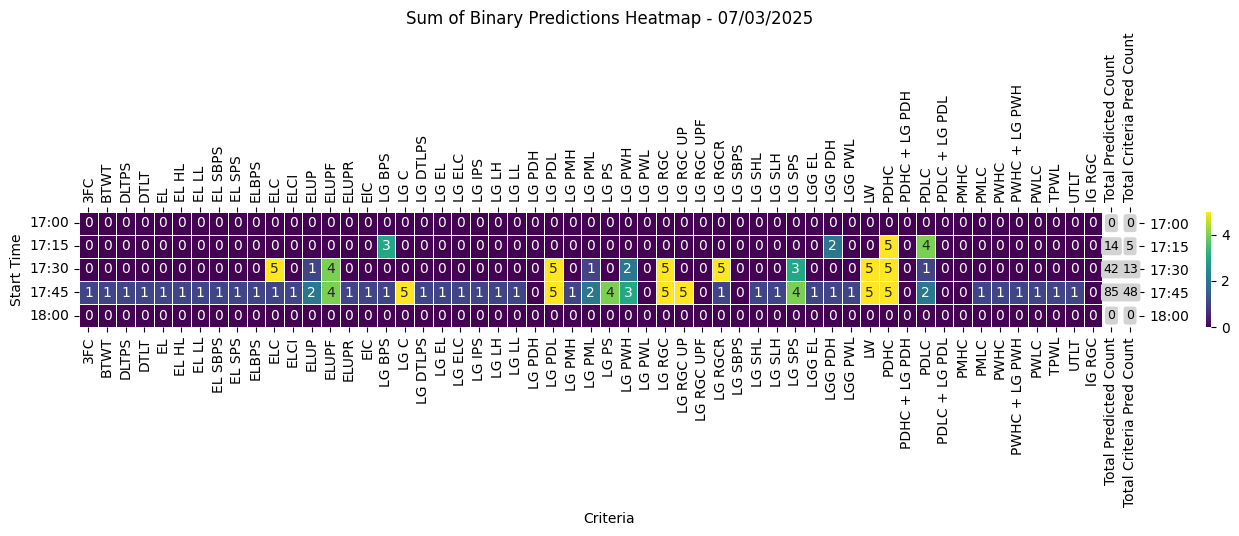

In [31]:
heatmap_data=plot_prediction_heatmap(prediction_combinations_df, input_date_comb, invert=True, interactive=False)